In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import camb
import torch 

In [2]:
def model_rs(ombh2,omch2,nnu, z_star):
  camb_params = camb.CAMBparams()
  camb_params.set_cosmology(ombh2=ombh2,omch2=omch2-ombh2,nnu=nnu,num_massive_neutrinos=0,mnu=0,H0=70) 
  camb_result = camb.get_background(camb_params)
  rs_star = camb_result.sound_horizon(z_star)
  return rs_star

In [5]:
#Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [7]:
wb_limits = [0.02, 0.024]
wbc_limits = [0.1, 0.18]
Neff_limits = [3, 3.1]

training_points = 5000
test_points = 1000

training_set = np.random.uniform(0,1,(3,training_points))
test_set = np.random.uniform(0,1,(3,test_points))

training_set[0] = training_set[0]*(wb_limits[1]-wb_limits[0])+wb_limits[0]
training_set[1] = training_set[1]*(wbc_limits[1]-wbc_limits[0])+wbc_limits[0]
training_set[2] = training_set[2]*(Neff_limits[1]-Neff_limits[0])+Neff_limits[0]

test_set[0] = test_set[0]*(wb_limits[1]-wb_limits[0])+wb_limits[0]
test_set[1] = test_set[1]*(wbc_limits[1]-wbc_limits[0])+wbc_limits[0]
test_set[2] = test_set[2]*(Neff_limits[1]-Neff_limits[0])+Neff_limits[0]

(3, 5000)

In [9]:
training_rs = np.array([model_rs(training_set[0][i],training_set[1][i],training_set[2][i], 1089) for i in range(training_points)])

test_rs = np.array([model_rs(test_set[0][i],test_set[1][i],test_set[2][i], 1089) for i in range(test_points)])

In [15]:
min_X = np.min(training_set, axis=1)
max_X = np.max(training_set, axis=1)

min_Y = np.min(training_rs)
max_Y = np.max(training_rs)

X = torch.tensor((training_set.T - min_X) / (max_X - min_X), dtype=torch.float)
Y = torch.tensor((training_rs.T - min_Y) / (max_Y - min_Y), dtype=torch.float)

In [49]:
# Rete neurale densa con 1 layer in input con 3 neuroni e un layer in output con 1 neurone, e 2 hidden layers con 32 neuroni.
# La funzione di attivazione è ReLU.
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [50]:
result = model(X)
print(result.shape)
print(result)

torch.Size([5000, 1])
tensor([[-0.1176],
        [-0.1730],
        [-0.1242],
        ...,
        [-0.2137],
        [-0.2246],
        [-0.2706]], grad_fn=<AddmmBackward0>)


In [51]:
squared_error = (result-Y)**2
print(torch.sum(squared_error))

tensor(11812587., grad_fn=<SumBackward0>)


In [52]:
# Train the noetwork on X, Y
import torch.optim as optim

#Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training loop
epochs = 100
batch_size = 32

for epoch in range(epochs):
    for i in range(0, len(X), batch_size):
        # Get the batch
        x_batch = X[i:i+batch_size]
        y_batch = Y[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        pred = model(x_batch)

        # Compute the loss
        loss = loss_fn(pred, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

    #Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

/home/elena/anaconda3/envs/acc-env/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/elena/anaconda3/envs/acc-env/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0665
Epoch [20/100], Loss: 0.0665
Epoch [30/100], Loss: 0.0667
Epoch [40/100], Loss: 0.0668
Epoch [50/100], Loss: 0.0668
Epoch [60/100], Loss: 0.0668
Epoch [70/100], Loss: 0.0668
Epoch [80/100], Loss: 0.0668
Epoch [90/100], Loss: 0.0667
Epoch [100/100], Loss: 0.0666
Training complete.


In [56]:
print("Shape di test_set.T:", test_set.T.shape)
print("Shape di min_X:", min_X.shape)
print("Shape di max_X:", max_X.shape)

Shape di test_set.T: (3, 100)
Shape di min_X: (3,)
Shape di max_X: (3,)


In [ ]:
test_set = test_set.T  # Cambia la forma da (3, 100) a (100, 3)

min_X = min_X[np.newaxis, :]  # Diventa (1, 3)
max_X = max_X[np.newaxis, :]  # Diventa (1, 3)

test_X = torch.tensor((test_set - min_X) / (max_X - min_X), dtype=torch.float)

In [59]:
pred_y = model(test_X)
pred_rs = pred_y * (max_Y - min_Y) + min_Y

pred_rs

tensor([[144.9346],
        [144.9640],
        [145.1590],
        [145.0962],
        [145.2791],
        [144.9942],
        [145.1142],
        [145.0996],
        [145.1571],
        [145.5613],
        [145.2289],
        [144.9949],
        [145.3824],
        [145.3830],
        [145.0248],
        [144.9451],
        [145.4121],
        [145.4077],
        [145.2447],
        [145.0171],
        [145.2189],
        [145.2886],
        [145.2512],
        [145.3127],
        [145.3945],
        [145.4801],
        [145.3603],
        [145.4308],
        [145.1569],
        [145.1400],
        [145.4083],
        [145.3185],
        [145.1285],
        [144.9889],
        [145.0153],
        [145.0192],
        [145.1805],
        [145.2409],
        [145.2570],
        [145.4693],
        [144.9484],
        [145.2525],
        [144.9418],
        [145.2115],
        [145.0523],
        [145.3964],
        [145.4074],
        [144.9458],
        [145.1800],
        [145.1435],


In [60]:
wb_ref = 0.02236
wbc_ref = 0.1432
Neff_ref = 3.04

Neff_random = np.random.uniform(Neff_limits[0], Neff_limits[1], 100)
rs_random = np.array([model_rs(wb_ref,wbc_ref,Neff_random[i], 1089) for i in range(100)])

In [63]:
test_set = np.array([[wb_ref, wbc_ref, Neff_random[i]] for i in range(100)])
test_X = torch.tensor((test_set - min_X) / (max_X - min_X), dtype=torch.float)
pred_y = model(test_X)
pred_rs = pred_y * (max_Y - min_Y) + min_Y

print(pred_rs.shape)

torch.Size([100, 1])


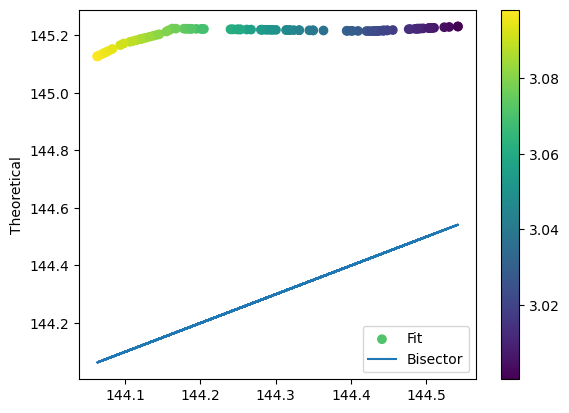

In [64]:
cb = plt.scatter(rs_random, pred_rs.detach().numpy(), c=Neff_random, label ='Fit')
plt.colorbar(cb)
plt.plot(rs_random, rs_random, label='Bisector')
plt.ylabel('Theoretical')
plt.legend()

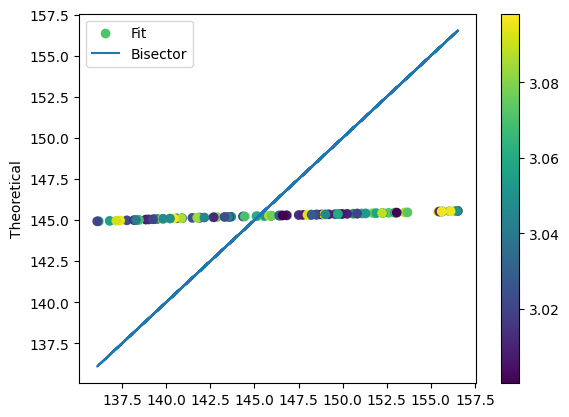

In [65]:
wbc_random = np.random.uniform(wbc_limits[0], wbc_limits[1], 100)
rs_random = np.array([model_rs(wb_ref,wbc_random[i],Neff_ref, 1089) for i in range(100)])

test_set = np.array([[wb_ref, wbc_random[i], Neff_ref] for i in range(100)])
test_X = torch.tensor((test_set - min_X) / (max_X - min_X), dtype=torch.float)
pred_y = model(test_X)
pred_rs = pred_y * (max_Y - min_Y) + min_Y

cb = plt.scatter(rs_random, pred_rs.detach().numpy(), c=Neff_random, label ='Fit')
plt.colorbar(cb)
plt.plot(rs_random, rs_random, label='Bisector')
plt.ylabel('Theoretical')
plt.legend()